In [71]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [72]:
!pip3 install cython
!pip3 install tables
!pip3 install statsmodels
!pip3 install -q keras
!pip3 install gensim
!pip3 install nltk

In [0]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

import tensorflow as tf

from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense
from keras.models import Model, load_model
from keras.layers import Input, CuDNNLSTM, Activation, Lambda, Dense, LeakyReLU, Conv1D,GlobalAveragePooling1D
from keras.layers import Dropout, Bidirectional,Concatenate, BatchNormalization, Flatten
from keras import backend as K, regularizers
from keras import optimizers, regularizers, initializers
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from keras.constraints import maxnorm
from keras.regularizers import l2

In [0]:
ratio = 6
data_dir = 'drive/My Drive/'
data_file = 'drive/My Drive/No_normalized_data.h5'

num_prev_values = 10
start = [10, 30]
# data_dir = 'drive/My Drive/btp/sem2_start/Prediction/'
# data_file = 'drive/My Drive/btp/sem2_start/Prediction/No_normalized_data.h5'

In [0]:
df = pd.read_hdf(data_file)

In [76]:
df.head()

,claim,num_rev,avg_rat,actualdis,dealdis,timeRem,num_type,recordtime,fixedEffects,day,...,day*avg_rat,dealdis*actualdis,num_type*actualdis,day*actualdis,num_type*dealdis,day*dealdis,day*num_type,deal_id,asin,y
0,0.0,92.0,4.513926,28.387097,31.971326,25178976.0,1.0,2.0,0.0,1.0,...,4.513926,907.57313,28.387097,28.387097,31.971326,31.971326,1.0,0013c9a8,B06XKFY3FR,0
1,0.0,92.0,4.513926,28.387097,31.971326,21573625.0,1.0,2.0,0.0,1.0,...,4.513926,907.57313,28.387097,28.387097,31.971326,31.971326,1.0,0013c9a8,B06XKFY3FR,1
2,1.0,92.0,4.513926,28.387097,31.971326,17950233.0,1.0,2.0,0.0,1.0,...,4.513926,907.57313,28.387097,28.387097,31.971326,31.971326,1.0,0013c9a8,B06XKFY3FR,1
3,2.0,92.0,4.513926,28.387097,31.971326,14338517.0,1.0,3.0,0.0,1.0,...,4.513926,907.57313,28.387097,28.387097,31.971326,31.971326,1.0,0013c9a8,B06XKFY3FR,1
4,3.0,92.0,4.513926,28.387097,31.971326,10708112.0,1.0,3.0,0.0,1.0,...,4.513926,907.57313,28.387097,28.387097,31.971326,31.971326,1.0,0013c9a8,B06XKFY3FR,1


In [77]:
df.columns
df.shape

(367606, 34)

In [0]:
def get_per_claim(df):

	claim = {}

	for index, row in df.iterrows():

		deal_id = row['deal_id']

		if(deal_id in claim):
			claim[deal_id].append(row[0])
		else:
			claim[deal_id] = [row[0]]

	return claim

In [0]:
def x_value(df, c0_cutoff, c1_cutoff, c2_cutoff, c3_cutoff, num_prev_values, start, claim):

	x = [[]]
	y = []
	x = df.iloc[:, [0, 1, 2, 3, 4, 5, 6, 9\
	 	# 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30 \
	 	]].values

	y = df.iloc[:, [0]].values
	
	actual_x = [[]]
	actual_y = []

	for i in range(len(x)):

		perClaim = []
		asin = (df.iloc[[i]]['deal_id'].values)[0]
		perClaim = claim.get(asin)
		idx = perClaim.index(x[i][0])
		
		for j in range(len(start)):
		
			l = []
			if((idx - start[j] - num_prev_values + 1) < 0):
				continue

			l = (perClaim[(idx-start[j]-num_prev_values+1):(idx-start[j]+1)])

			for k in range(len(x[i]) - 1):
				l.append(x[i][k])

			l.append(start[j])
			actual_x.append(l)
			actual_y.append(y[i])

	actual_y = np.asarray(actual_y)
	actual_y[actual_y <= c0_cutoff] = 0
	actual_y[actual_y > c3_cutoff] = 4
	actual_y[actual_y > c2_cutoff] = 3
	actual_y[actual_y > c1_cutoff] = 2
	actual_y[actual_y > c0_cutoff] = 1
	
	return actual_x, actual_y


In [0]:
def equalSplit(x, y, ratio):

	lenY1 = np.count_nonzero(y == 1)
	lenY2 = np.count_nonzero(y == 2)
	lenY3 = np.count_nonzero(y == 3)
	lenY4 = np.count_nonzero(y == 4)
	lenY0 = len(y) - lenY1 - lenY2 - lenY3 - lenY4

	y0 = y[np.where(y == 0), :][0]
	x0 = x[np.where(y == 0), :][0]
	index = np.random.choice(y0.shape[0], min(ratio*lenY4, lenY0), replace = False)
	x0 = x0[index]
	y0 = y0[index]

	y1 = y[np.where(y == 1), :][0]
	x1 = x[np.where(y == 1), :][0]
	index = np.random.choice(y1.shape[0], min(ratio*lenY4, lenY1), replace = False)
	x1 = x1[index]
	y1 = y1[index]
	
	y2 = y[np.where(y == 2), :][0]
	x2 = x[np.where(y == 2), :][0]
	index = np.random.choice(y2.shape[0], min(ratio*lenY4, lenY2), replace = False)
	x2 = x2[index]
	y2 = y2[index]
	
	y3 = y[np.where(y == 3), :][0]
	x3 = x[np.where(y == 3), :][0]
	index = np.random.choice(y3.shape[0], min(ratio*lenY4, lenY3), replace = False)
	x3 = x3[index]
	y3 = y3[index]

	y4 = y[np.where(y == 4), :][0]
	x4 = x[np.where(y == 4), :][0]
	index = np.random.choice(y4.shape[0], min(ratio*lenY4, lenY4), replace = False)
	x4 = x4[index]
	y4 = y4[index]

	x = np.vstack((x0, x1))
	x = np.vstack((x, x2))
	x = np.vstack((x, x3))
	x = np.vstack((x, x4))
	y = np.vstack((y0, y1))
	y = np.vstack((y, y2))
	y = np.vstack((y, y3))
	y = np.vstack((y, y4))

	return x, y

In [0]:
def StandardModel(numFeatures, Loss, optimizer):

	model = Sequential()
	model.add(Dense(12, input_dim = numFeatures, activation = 'relu'))
	model.add(Dense(8, activation = 'relu'))
	model.add(Dense(5, activation = 'softmax'))
	model.compile(loss = Loss, optimizer = optimizer, metrics = ['accuracy'])
	# model.fit(X, Y, epochs=150, batch_size=10,  verbose=2)
	# predictions = model.predict(X)

In [0]:
def define_model():

	input = Input(shape = INPUT_SHAPE_1, dtype = 'float32', name = 'features')

	x = Dense(200, kernel_regularizer = regularizers.l2(1e-3) ,name = 'Fully_Connected_Layer_1')(input)
	x = BatchNormalization()(x)
	x = LeakyReLU(alpha=0.01)(x)
	x = Dropout(DROPOUT,  name = 'Dropout_Regularization_1')(x)

	x = Dense(150, kernel_regularizer = regularizers.l2(1e-3), name = 'Fully_Connected_Layer_2')(x)
	x = BatchNormalization()(x)
	x = LeakyReLU(alpha=0.01)(x)
	x = Dropout(DROPOUT,  name = 'Dropout_Regularization_2')(x)

	x = Dense(90, kernel_regularizer = regularizers.l2(1e-3), name = 'Fully_Connected_Layer_3')(x)
	x = BatchNormalization()(x)
	x = LeakyReLU(alpha=0.01)(x)
	x = Dropout(DROPOUT,  name = 'Dropout_Regularization_3')(x)

	x = Dense(50, kernel_regularizer = regularizers.l2(1e-3), name = 'Fully_Connected_Layer_4')(x)
	x = BatchNormalization()(x)
	x = LeakyReLU(alpha=0.01)(x)
	x = Dropout(DROPOUT,  name = 'Dropout_Regularization_4')(x)

	output = Dense(5, activation = 'softmax', name = 'Fully_Connected_Layer_5')(x)

	model = Model(inputs = [input], outputs = [output], name = 'my_model')

	return model

In [0]:
def define_model_2():

  input = Input(shape = INPUT_SHAPE_1, dtype = 'float32', name = 'features')

  x = Dense(1024 ,name = 'Fully_Connected_Layer_0')(input)
  # 	x = BatchNormalization()(x)
  x = LeakyReLU(alpha=0.01)(x)


  x = Dense(512 ,name = 'Fully_Connected_Layer_1')(x)
  # 	x = BatchNormalization()(x)
  x = LeakyReLU(alpha=0.01)(x)
  # 	x = Dropout(DROPOUT,  name = 'Dropout_Regularization_1')(x)

  x = Dense(256, name = 'Fully_Connected_Layer_2')(x)
  # 	x = BatchNormalization()(x)
  x = LeakyReLU(alpha=0.01)(x)
  # 	x = Dropout(DROPOUT,  name = 'Dropout_Regularization_2')(x)

  x = Dense(128, name = 'Fully_Connected_Layer_3')(x)
  # 	x = BatchNormalization()(x)
  x = LeakyReLU(alpha=0.01)(x)
  # 	x = Dropout(DROPOUT,  name = 'Dropout_Regularization_3')(x)

  x = Dense(64, name = 'Fully_Connected_Layer_4')(x)
  # 	x = BatchNormalization()(x)
  x = LeakyReLU(alpha=0.01)(x)
  # 	x = Dropout(DROPOUT,  name = 'Dropout_Regularization_4')(x)

  output = Dense(5, activation = 'softmax', name = 'Fully_Connected_Layer_5')(x)

  model = Model(inputs = [input], outputs = [output], name = 'my_model')

  return model

In [0]:
def run_model(X_train, X_val, Y_train, Y_val, model):

	print(model.summary())
	model.compile(loss='categorical_crossentropy', optimizer = optimizers.Adam(), metrics=['accuracy'])
	earlystop = EarlyStopping(monitor = 'val_loss', patience = PAT)
	check_pt = ModelCheckpoint(data_dir + 'model_.h5', save_best_only=True)
	callbacks_list = [earlystop, check_pt]

	trained_model = model.fit(X_train, [Y_train], epochs = EPOCHS, batch_size = BATCH_SIZE, shuffle = True, \
								validation_data = [X_val, [Y_val]], callbacks = callbacks_list)

	return trained_model, model

In [0]:
def run_model_2(X_train, X_val, Y_train, Y_val, model):

	print(model.summary())
	model.compile(loss='categorical_crossentropy', optimizer = optimizers.Adam(), metrics=['accuracy'])
# 	earlystop = EarlyStopping(monitor = 'val_loss', patience = PAT)
# 	check_pt = ModelCheckpoint(data_dir + 'model_.h5', save_best_only=True)
# 	callbacks_list = [earlystop, check_pt]

	trained_model = model.fit(X_train, [Y_train], epochs = EPOCHS, batch_size = BATCH_SIZE, shuffle = True, \
								validation_data = [X_val, [Y_val]])

	return trained_model, model

In [0]:
def model_history(trained_model):

	fig, axs = plt.subplots(1,2,figsize=(15,5))

	axs[0].plot(trained_model.history['loss'])
	axs[0].plot(trained_model.history['val_loss'])
	axs[0].set_title('Model Loss')
	axs[0].set_ylabel('Loss')
	axs[0].set_xlabel('Epoch')
	axs[0].legend(['Train', 'Validation'], loc='upper right')

	axs[1].plot(trained_model.history['acc'])
	axs[1].plot(trained_model.history['val_acc'])
	axs[1].set_title('Model Accuracy')
	axs[1].set_ylabel('Accuracy')
	axs[1].set_xlabel('Epoch')
	axs[1].legend(['Train', 'Validation'], loc='upper right')
	plt.show()

x and y created
x and y equally splitted
10792 10792
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
features (InputLayer)        (None, 18)                0         
_________________________________________________________________
Fully_Connected_Layer_1 (Den (None, 200)               3800      
_________________________________________________________________
batch_normalization_1 (Batch (None, 200)               800       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 200)               0         
_________________________________________________________________
Dropout_Regularization_1 (Dr (None, 200)               0         
_________________________________________________________________
Fully_Connected_Layer_2 (Den (None, 150)               30150     
_________________________________________________________________
batch_normalization_2 (

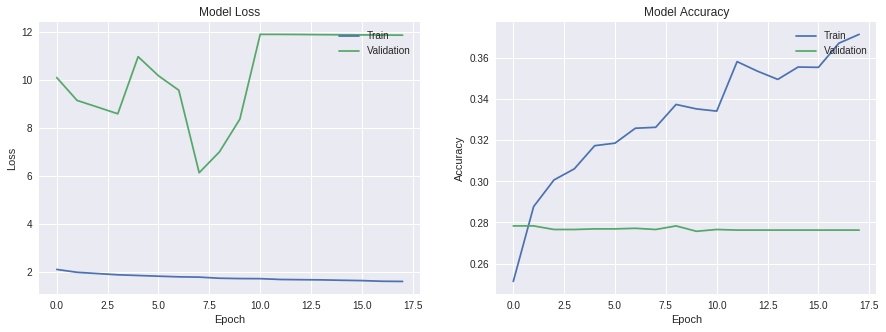

In [87]:
claim = get_per_claim(df)
x, y = x_value(df, 20, 40, 60, 80, num_prev_values, start, claim)
x = x[1:]
x = np.asarray(x)
print('x and y created')
x, y = equalSplit(x, y, ratio)
print('x and y equally splitted')

from sklearn import preprocessing

X_scaled = preprocessing.normalize(x)
y = y.astype(int)
x_train, x_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.4, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.2, random_state=42)

# print(np.count_nonzero(y_train == 4))
# print(np.count_nonzero(y_train == 3))
# print(np.count_nonzero(y_train == 2))
# print(np.count_nonzero(y_train == 1))
# print(np.count_nonzero(y_train == 0))

y_train = np.squeeze(np.eye(5)[y_train.reshape(-1)])
print(len(X_scaled), len(y))
y_val = np.squeeze(np.eye(5)[y_val.reshape(-1)])
y_test = np.squeeze(np.eye(5)[y_test.reshape(-1)])

# print('Training started')
# clf = MLPClassifier()
# clf.fit(x_train, y_train)

# print('Testing Started')
# y_pred = clf.predict(x_train)
# print('Train Accuracy - ', accuracy_score(y_train, y_pred))
# y_pred = clf.predict(x_test)
# print('Test Accuracy - ', accuracy_score(y_test, y_pred))
# print(len(x_train), len(x_test))

INPUT_SHAPE_1 = (8 + num_prev_values, )
EPOCHS = 100
BATCH_SIZE = 512
DROPOUT = 0.15
PAT = 10

K.clear_session()
model = define_model()
trained_model, model = run_model(x_train, x_val, y_train, y_val, model)
model_history(trained_model)

# y_pred = (model.predict(x_train)).argmax(axis=-1)
# y_train = [np.where(r==1)[0][0] for r in y_train]
# print(accuracy_score(y_train, y_pred))

In [88]:
y_pred = (model.predict(x_test)).argmax(axis=-1)
y_test = [np.where(r==1)[0][0] for r in y_test]
print(accuracy_score(y_test, y_pred))

0.2962962962962963


In [89]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.30      1.00      0.46       256
           1       0.00      0.00      0.00       243
           2       0.00      0.00      0.00       196
           3       0.00      0.00      0.00       125
           4       0.00      0.00      0.00        44

   micro avg       0.30      0.30      0.30       864
   macro avg       0.06      0.20      0.09       864
weighted avg       0.09      0.30      0.14       864



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [90]:
y_pred = (model.predict(x_train)).argmax(axis=-1)
y_train = [np.where(r==1)[0][0] for r in y_train]
print(accuracy_score(y_pred, y_train))

0.27181467181467184


In [91]:
from sklearn.metrics import classification_report
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.27      1.00      0.43      1760
           1       0.00      0.00      0.00      1766
           2       0.00      0.00      0.00      1617
           3       0.00      0.00      0.00      1040
           4       0.00      0.00      0.00       292

   micro avg       0.27      0.27      0.27      6475
   macro avg       0.05      0.20      0.09      6475
weighted avg       0.07      0.27      0.12      6475



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [92]:
y_pred = (model.predict(x_val)).argmax(axis=-1)
y_val = [np.where(r==1)[0][0] for r in y_val]
print(accuracy_score(y_val, y_pred))

0.27628149435273675


In [93]:
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.28      1.00      0.43       954
           1       0.00      0.00      0.00       961
           2       0.00      0.00      0.00       848
           3       0.00      0.00      0.00       531
           4       0.00      0.00      0.00       159

   micro avg       0.28      0.28      0.28      3453
   macro avg       0.06      0.20      0.09      3453
weighted avg       0.08      0.28      0.12      3453



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
